In [1]:
#!pip install torch
#!pip install torchvision
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import json
from normalizer import getDataFromJSON, subSample
# Device configuration - If you have CUDA configured, you must use it. Try training with CPU and observe what happens
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Setting a seed for torch
'''step - Your seed will be the last 6 digits of your A# excluding any leading zeros'''
torch.manual_seed(195322) 

/home/robjohnson/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
# All of our fields have names, but we need them in numbers, so define a dictionary to convert.
global magDict
magDict = {
    'TOTUSJH': 0,
    'TOTBSQ': 1,
    'TOTPOT': 2,
    'TOTUSJZ': 3,
    'ABSNJZH': 4,
    'SAVNCPP': 5,
    'USFLUX': 6,
    'TOTFZ': 7,
    'MEANPOT': 8,
    'EPSZ': 9,
    'SHRGT45': 10,
    'MEANSHR': 11,
    'MEANGAM': 12,
    'MEANGBT': 13,
    'MEANGBZ': 14,
    'MEANGBH': 15,
    'MEANJZH': 16,
    'TOTFY': 17,
    'MEANJZD': 18,
    'MEANALP': 19,
    'TOTFX': 20,
    'EPSY': 21,
    'EPSX': 22,
    'R_VALUE': 23,
    'RBZ_VALUE': 24,
    'RBT_VALUE': 25,
    'RBP_VALUE': 26,
    'FDIM': 27,
    'BZ_FDIM': 28,
    'BT_FDIM': 29,
    'BP_FDIM': 30,
    'PIL_LEN': 31,
    'XR_MAX': 32
}

In [4]:
# This file has 77270 data points. 
%time train1, labels1 = subSample(path="data/train_partition1_data.json", earlyStop=5000, device=device)

Now loading event 1/785
Now loading event 101/785
Now loading event 201/785
Now loading event 301/785
Now loading event 401/785
Now loading event 501/785
Now loading event 601/785
Now loading event 701/785
785 lines loaded.
CPU times: user 20.9 s, sys: 2.26 s, total: 23.1 s
Wall time: 23.2 s


In [5]:
# This file has 93767 data points. 
%time train2, labels2 = subSample(path="data/train_partition2_data.json", earlyStop=5000, device=device)

Now loading event 1/300
Now loading event 101/300
Now loading event 201/300
300 lines loaded.
CPU times: user 16.5 s, sys: 1.98 s, total: 18.5 s
Wall time: 18.5 s


In [6]:
# This file has 42986 data points. 
%time train3, labels3 = subSample(path="data/train_partition3_data.json", earlyStop=5000, device = device)

Now loading event 1/585
Now loading event 101/585
Now loading event 201/585
Now loading event 301/585
Now loading event 401/585
Now loading event 501/585
585 lines loaded.
CPU times: user 13 s, sys: 907 ms, total: 14 s
Wall time: 14 s


In [7]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [9]:
train1.shape

torch.Size([785, 33, 60])


RuntimeError: shape '[100]' is invalid for input of size 1554300

In [10]:
train2.shape

torch.Size([300, 33, 60])

In [11]:
train3.shape

torch.Size([585, 33, 60])

In [12]:
train1[0]

tensor([[4.2348e+02, 4.2958e+02, 4.2243e+02,  ..., 3.7410e+02, 3.7253e+02,
         3.6715e+02],
        [8.0577e+09, 8.0768e+09, 8.0405e+09,  ..., 7.1063e+09, 7.0274e+09,
         7.0019e+09],
        [1.6010e+23, 1.6057e+23, 1.5958e+23,  ..., 1.4230e+23, 1.4215e+23,
         1.4222e+23],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.4633e-04, 0.0000e+00,
         0.0000e+00],
        [4.0000e+00, 0.0000e+00, 1.0000e+00,  ..., 7.0000e+00, 2.0000e+00,
         5.0000e+00],
        [1.6718e-07, 1.6202e-07, 1.8156e-07,  ..., 1.6528e-07, 1.7179e-07,
         2.2089e-07]])

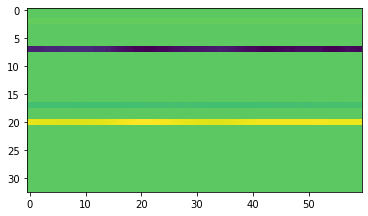

In [13]:
plt.imshow(train2[1])
plt.show()

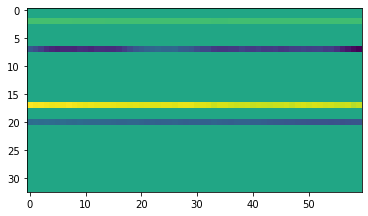

In [24]:
plt.imshow(train1[1])
plt.show()

In [15]:
train1.view(-1,1,33,60)[:,0,:,:].shape

torch.Size([785, 33, 60])

In [29]:
# Append in to a single tensor
X = torch.cat((train1, train2,train3),0)
print(X.shape)
X = X.reshape(-1, 1, 33, 60)
print(X.shape)
X = X[:,:,:28,:28] # This does not look like a good idea...
batch_size = X.shape[0]
X = X.to(torch.float)
# this? This gives me pain
for i in range(batch_size): 
  # print(X[i])
  # isn't this going to only normalize each frame? instead, shouldn't we normalize based on data type?
    min_x = torch.min(X[i])
    X[i] -= min_x
    X[i] /= torch.max(X[i]).item()

# here is how I'm going to change it:
for i in range(X.shape[2]): # the number of types of measurements
    min_x = torch.min(X[:,:,i,:])
    X[:,:,i,:] -= min_x
    X[:,:,i,:] /= torch.max(X[:,:,i,:]).item()
    
# X=torch.nan_to_num(X) # This threw an error, but subSample gets rid of NAN values.
X.shape

torch.Size([1670, 33, 60])
torch.Size([1670, 1, 33, 60])


torch.Size([1670, 1, 28, 28])

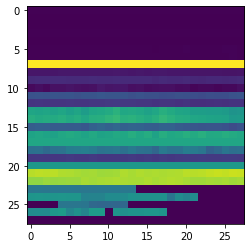

(tensor(0.), tensor(0.9223))

In [31]:
plt.imshow(X[2,0,:,:])
plt.show()
torch.min(X[2,0,:,:]), torch.max(X[2,0,:,:])

In [32]:
'''
Create the architecture 

'''

# consider how this would need to change to get all the data instead of just that one square

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # you can use sequential of not 
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 4, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(196, 120),
            nn.ReLU(),
            nn.Linear(120, 96),
            nn.ReLU(),
            nn.Linear(96, 64),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (4, 4, 4)),
            nn.ConvTranspose2d(4, 16, 3, stride = 1),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(16, 1, 3, stride = 1),
            nn.Upsample(scale_factor=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [35]:
'''
Define your training routine,
your optimizer, your loss function.
Everything you need to train the model
'''
model = Autoencoder()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

n_epochs = 50

model.to(device)

train_loader = torch.utils.data.DataLoader(X, batch_size = 32, num_workers = 0)
for epoch in range(1, n_epochs+1):
    train_loss = 0.0
    for data in train_loader:
        data.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, data)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
    train_loss /= len(train_loader)
    print(f'epoch {epoch} : \t training loss {train_loss}')


epoch 1 : 	 training loss 19.396039508423716
epoch 2 : 	 training loss 18.230817702581298
epoch 3 : 	 training loss 18.040918921524625
epoch 4 : 	 training loss 17.93328084810725
epoch 5 : 	 training loss 17.885345744636822
epoch 6 : 	 training loss 17.85245236360802
epoch 7 : 	 training loss 17.839099740082364
epoch 8 : 	 training loss 17.81973345099755
epoch 9 : 	 training loss 17.80847294825428
epoch 10 : 	 training loss 17.801561915649557
epoch 11 : 	 training loss 17.79428071345923
epoch 12 : 	 training loss 17.797829274861318
epoch 13 : 	 training loss 17.782025980499554
epoch 14 : 	 training loss 17.78052949455549
epoch 15 : 	 training loss 17.77806836254192
epoch 16 : 	 training loss 17.768863662233894
epoch 17 : 	 training loss 17.76780528617355
epoch 18 : 	 training loss 17.75779628978585
epoch 19 : 	 training loss 17.75282579547954
epoch 20 : 	 training loss 17.740766943625683
epoch 21 : 	 training loss 17.731010967830443
epoch 22 : 	 training loss 17.714692914261008
epoch 2

In [36]:
model.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=196, out_features=120, bias=True)
    (8): ReLU()
    (9): Linear(in_features=120, out_features=96, bias=True)
    (10): ReLU()
    (11): Linear(in_features=96, out_features=64, bias=True)
    (12): ReLU()
  )
  (decoder): Sequential(
    (0): Unflatten(dim=1, unflattened_size=(4, 4, 4))
    (1): ConvTranspose2d(4, 16, kernel_size=(3, 3), stride=(1, 1))
    (2): Upsample(scale_factor=2.0, mode=nearest)
    (3): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(1, 1))
    (4): Upsample(scale_factor=2.0, mode=nearest)
    (5): Sigmoid()
  

In [40]:
X1_vector = model.encoder(X[:,:,:,:])
X1_vector = X1_vector.detach().numpy()
print(X1_vector.shape)
print(X.shape)

(1670, 64)
torch.Size([1670, 1, 28, 28])


In [46]:
X1_vector[4]

array([0.        , 1.8099934 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.3157406 , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.0426115 , 0.        , 1.5827414 ,
       0.8905652 , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.7297735 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.10715877, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.9355048 ,
       0.        , 0.        , 1.0150832 , 0.        , 0.        ,
       0.        , 1.3872658 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.12167436, 0.        , 0.        , 0.        ], dtype=float32)

In [38]:
X1_vector

array([[0.       , 1.9393485, 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 1.3846765, 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 2.8108666, 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 1.2391716, 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 1.2935016, 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 1.9919354, 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

In [47]:
#k-mean analysis
kmeans = KMeans(n_clusters = 5)
kmeans.fit(X1_vector)


KMeans(n_clusters=5)

In [48]:
#k-mean labels
kmeans.labels_

array([3, 4, 2, ..., 4, 4, 0], dtype=int32)

In [49]:
X1_fit

NameError: name 'X1_fit' is not defined

In [50]:
from sklearn.manifold import TSNE

In [51]:
#turn vectors into two dimensions
X_embed = TSNE(n_components=2).fit_transform(X1_vector)

In [52]:
X_embed.shape

(1670, 2)

In [53]:
x_em = X_embed[:, 0]
y_em = X_embed[:,1]

In [57]:
original = np.array([0]*train1.shape[0]+[1]*train2.shape[0]+[2]*train3.shape[0])
a = train1.shape[0]
b = a + train2.shape[0]

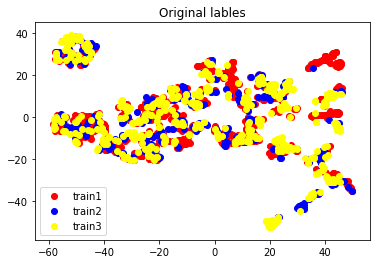

In [58]:
# labeled by partition
plt.scatter(x_em[:a], y_em[:a], c= 'red',label = 'train1')
plt.scatter(x_em[a:b], y_em[a:b], c='blue', label = 'train2')
plt.scatter(x_em[b:], y_em[b:], c='yellow', label = 'train3')
plt.legend()
plt.title('Original lables')
plt.show()

In [59]:
X1_vector[3]

array([0.        , 2.9207416 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 2.139209  , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.9631543 , 0.        , 2.9883661 ,
       0.6590673 , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.6679616 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.2177769 , 0.        , 0.        ,
       0.        , 1.5650522 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.50430804, 0.        , 0.        , 0.        ], dtype=float32)

In [60]:
kmeans.labels_

array([3, 4, 2, ..., 4, 4, 0], dtype=int32)

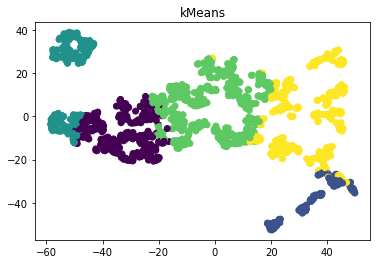

In [61]:
# This is labeled with the KMeans labels
plt.scatter(x_em, y_em, c=kmeans.labels_)
plt.title('kMeans')
plt.show()